In [6]:
%matplotlib inline
from spectral_density_functions import *
from spectral_density_functions import S_k_omega, convolve, S_k_omega_conv
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import gaussian

In [70]:
l0=532e-9
bp=100e-9
n_points=4e4
l=np.linspace(l0-bp/2,l0+bp/2,n_points)
FWHM=0.2e-10*4
response=gaussian(n_points,FWHM/(bp/n_points))

'''Plasma Parameters'''
n_e=5e17#cm^-3
A=12#Ion mass
T_i=500#in eV
T_e=100#in eV
Z=Z_nLTE(T_e, np.genfromtxt('zb_Spk_C_NLTE.txt', delimiter='       ', skip_header=4))
V=0

theta=45#degrees

skw=S_k_omega_conv(l, l0, response, theta, A, T_e,T_i,n_e,Z,v_fi=V)

lambda_De=7.43*(T_e/n_e)**0.5 #in m
k=4*np.pi*np.sin(theta/2.0)/l0
alpha=np.abs(1/(k*lambda_De))

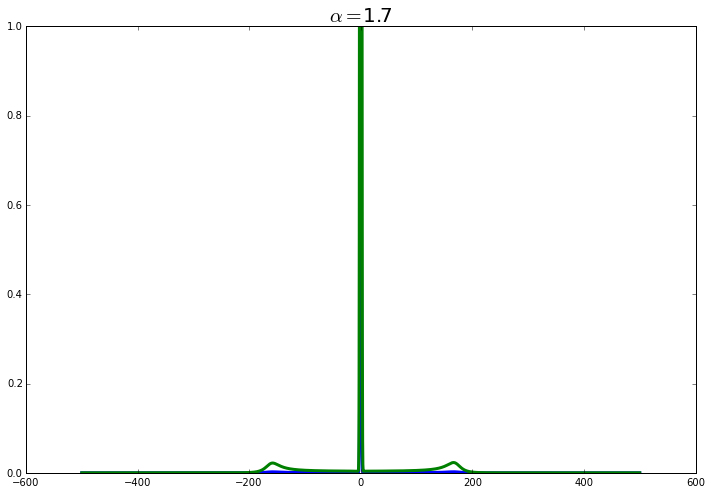

In [71]:
fig, ax=plt.subplots(figsize=(12,8))
ax.plot((l-l0)*1e10, skw, lw=3)
ax.plot((l-l0)*1e10, skw*1e1, lw=3)
ax.set_ylim([0,1])
ax.set_title(r'$\alpha= $'+str(round(alpha,1)), fontsize=20)

In [7]:
FWHM/(bp/n_points)

20.000000000000004

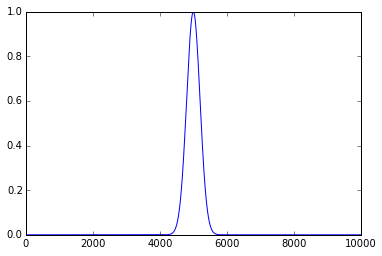

In [9]:
gaussian(10000,200)

In [ ]:
def S_k_omega(lambda_range, lambda_in, theta, A, T_e,T_i,n_e,Z, v_fi=0, v_fe=0):
    '''
    Returns a normalised spectral density function.
    Implements the model of Sheffield (2nd Ed.)
    One ion, one electron species with independent temeperatures
    Electron velocity is with respect to ion velocity
    Returns S(k,w) for each wavelength in lambda_range assuming
    input wavelength lambda_in. Both in metres
    Theta is angle between k_in and k_s in degrees
    A i atomic mass, Z is ion charge
    T_e, T_i in eV, n_e in cm^-3
    V_fi and V_fe in m/s
    '''
    #physical parameters
    pi=np.pi
    m_i=m_p*A
    om_pe=5.64e4*n_e**0.5#electron plasma frequency
    #define omega and k as in Sheffield 113
    ki=2*pi/lambda_in
    omega_i=((c*ki)**2+om_pe**2)**0.5

    ks=2*pi/lambda_range
    omega_s=((c*ks)**2+om_pe**2)**0.5
    
    th=theta/180.0*np.pi#convert to radians for cosine function
    k=(ks**2+ki**2-2*ks*ki*np.cos(th))**0.5
    omega=omega_s-omega_i
    
    #define dimensionless parameters ala Sheffield
    a=sqrt(2*e*T_e/m_e)
    b=sqrt(2*e*T_i/m_i)
    x_e=(omega/k+v_fe+v_fi)/a
    x_i=(omega/k+v_fi)/b
    lambda_De=7.43*(T_e/n_e)**0.5 #Debeye length in m
    #the all important alpha parameter
    alpha=1/(k*lambda_De)
    #set up the Fadeeva function
    w=scipy.special.wofz
    chi_i=alpha**2*Z*T_e/T_i*(1+1j*sqrt(pi)*x_i*w(x_i)) #ion susceptibility
    chi_e=alpha**2*(1+1j*sqrt(pi)*x_e*w(x_e))#electron susceptibility
    epsilon=1+chi_e+chi_i#dielectric function
    fe0=1/(sqrt(pi)*a)*np.exp(-x_e**2)#electron Maxwellian function
    fi0=1/(sqrt(pi)*b)*np.exp(-x_i**2)#ion Maxwellian
    Skw=2*pi/k*(abs(1-chi_e/epsilon)**2*fe0+Z*abs(chi_e/epsilon)**2*fi0)
    return Skw/Skw.max() #normalise the spectrum